# End to End Test Results

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def generate_zooms_plot(df, dataset):
    zooms = [int(path.split('/')[2]) for path in df['Name'][:-1]]
    # Create a new figure
    plt.figure()

    # Create a scatter plot
    plt.scatter(zooms, df['Median Response Time'][:-1])

    # Add title and labels
    plt.title(dataset)
    plt.xlabel('Zoom')
    plt.ylabel('Time (ms)')

    # Display the plot
    plt.show()   

In [6]:
bucket_name = 'nasa-eodc-data-store'
s3_dir = 'e2e/results/2023-08-01_11_56_55'  # Replace with the actual S3 object key.
def s3_url(object_key):
    return f's3://{bucket_name}/{s3_dir}/{object_key}'

In [19]:
zarr_specs = pd.read_csv(f"s3://{bucket_name}/e2e/zarr_info.csv")
zarr_specs.head()

,source,variable,shape,lat_resolution,lon_resolution,chunks,chunk_size_mb,number_coord_chunks,dtype,compression
0,s3://veda-data-store-staging/EIS/zarr/FWI-GEOS...,NaN,"{'time': 26880, 'lat': 533, 'lon': 1152}",0.25,0.3125,"{'time': 120, 'lat': 100, 'lon': 100}",4.577637,3,float32,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, ..."
1,s3://power-analysis-ready-datastore/power_901_...,NaN,"{'time': 492, 'lat': 361, 'lon': 576}",0.50,0.6250,"{'time': 492, 'lat': 25, 'lon': 25}",2.346039,43,float64,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, ..."
2,s3://cmip6-pds/CMIP6/CMIP/NASA-GISS/GISS-E2-1-...,NaN,"{'time': 1980, 'lat': 90, 'lon': 144}",2.00,2.5000,"{'time': 600, 'lat': 90, 'lon': 144}",29.663086,3,float32,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, ..."
3,https://ncsa.osn.xsede.org/Pangeo/pangeo-forge...,NaN,"{'time': 15044, 'zlev': 1, 'lat': 720, 'lon': ...",0.25,0.2500,"{'time': 1, 'zlev': 1, 'lat': 720, 'lon': 1440}",1.977539,4,int16,Zlib(level=4)
4,s3://yuvipanda-test1/cmr/gpm3imergdl.zarr,NaN,"{'time': 8149, 'lon': 3600, 'lat': 1800}",0.10,0.1000,"{'time': 10, 'lon': 3600, 'lat': 1800}",247.192383,3,float32,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, ..."


# GPM IMERG `preciptationCal` (0.1°x0.1°)

In [7]:
object_key = 'gpm3imergdl_urls_stats.csv'
gpmimerg_df = pd.read_csv(s3_url(object_key))
gpmimerg_df.head()

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,GET,/tiles/0/0/0.png?reference=False&variable=prec...,1,1,459.645825,459.645825,459.645825,459.645825,169.0,0.031174,...,460,460,460,460,460,460,460,460,460,460
1,GET,/tiles/1/1/1.png?reference=False&variable=prec...,1,1,251.300486,251.300486,251.300486,251.300486,169.0,0.031174,...,250,250,250,250,250,250,250,250,250,250
2,GET,/tiles/2/0/2.png?reference=False&variable=prec...,1,1,395.948256,395.948256,395.948256,395.948256,169.0,0.031174,...,400,400,400,400,400,400,400,400,400,400
3,GET,/tiles/2/2/1.png?reference=False&variable=prec...,1,1,289.734276,289.734276,289.734276,289.734276,169.0,0.031174,...,290,290,290,290,290,290,290,290,290,290
4,GET,/tiles/2/3/1.png?reference=False&variable=prec...,1,1,334.808429,334.808429,334.808429,334.808429,169.0,0.031174,...,330,330,330,330,330,330,330,330,330,330


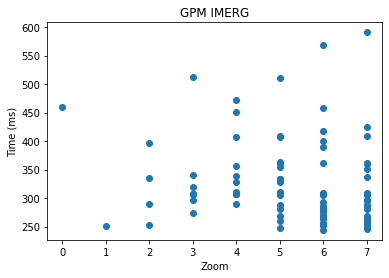

In [8]:
generate_zooms_plot(gpmimerg_df, 'GPM IMERG')

# GOES FWI (0.25°x0.3125°) results

In [9]:
object_key = 'FWI-GEOS-5-Hourly_urls_stats.csv'
goes_df = pd.read_csv(s3_url(object_key))
goes_df.head()

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,GET,/tiles/0/0/0.png?reference=False&variable=GEOS...,1,0,1344.492412,1344.492412,1344.492412,1344.492412,6287.0,0.027709,...,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300
1,GET,/tiles/1/0/1.png?reference=False&variable=GEOS...,1,0,543.074605,543.074605,543.074605,543.074605,4532.0,0.027709,...,540,540,540,540,540,540,540,540,540,540
2,GET,/tiles/2/1/0.png?reference=False&variable=GEOS...,1,0,408.714559,408.714559,408.714559,408.714559,693.0,0.027709,...,410,410,410,410,410,410,410,410,410,410
3,GET,/tiles/2/2/1.png?reference=False&variable=GEOS...,2,0,490.000000,501.913269,485.667866,518.158671,14358.0,0.055417,...,520,520,520,520,520,520,520,520,520,520
4,GET,/tiles/2/2/2.png?reference=False&variable=GEOS...,1,0,429.382500,429.382500,429.382500,429.382500,8664.0,0.027709,...,430,430,430,430,430,430,430,430,430,430


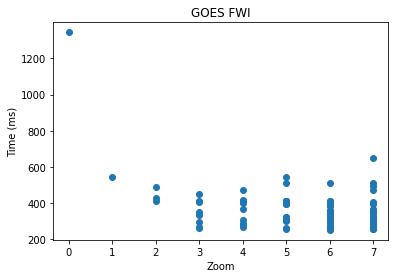

In [10]:
generate_zooms_plot(goes_df, 'GOES FWI')

# NOAA OISST Reference (0.25° x 0.25°) Results

In [11]:
object_key = 'aws-noaa-oisst-avhrr-only_urls_stats.csv'
noaa_oisst_df = pd.read_csv(s3_url(object_key))
noaa_oisst_df.head()

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,GET,/tiles/0/0/0.png?reference=True&variable=sst&r...,1,0,3002.373254,3002.373254,3002.373254,3002.373254,21983.0,0.019702,...,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000
1,GET,/tiles/1/0/1.png?reference=True&variable=sst&r...,1,0,649.828802,649.828802,649.828802,649.828802,14524.0,0.019702,...,650,650,650,650,650,650,650,650,650,650
2,GET,/tiles/2/1/0.png?reference=True&variable=sst&r...,1,0,427.692081,427.692081,427.692081,427.692081,4601.0,0.019702,...,430,430,430,430,430,430,430,430,430,430
3,GET,/tiles/2/1/1.png?reference=True&variable=sst&r...,1,0,449.075035,449.075035,449.075035,449.075035,22783.0,0.019702,...,450,450,450,450,450,450,450,450,450,450
4,GET,/tiles/2/1/3.png?reference=True&variable=sst&r...,1,0,447.181913,447.181913,447.181913,447.181913,693.0,0.019702,...,450,450,450,450,450,450,450,450,450,450


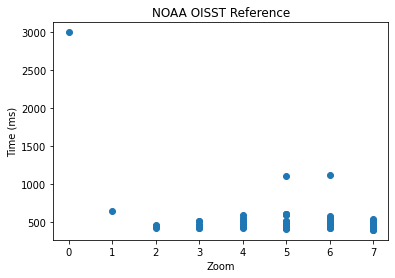

In [12]:
generate_zooms_plot(noaa_oisst_df, 'NOAA OISST Reference')

# POWER Results (0.5° x 0.625°)

In [13]:
object_key = 'power_901_monthly_meteorology_utc_urls_stats.csv'
power_df = pd.read_csv(s3_url(object_key))
power_df.head()

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,GET,/tiles/0/0/0.png?reference=False&variable=TS&r...,1,0,5519.313156,5519.313156,5519.313156,5519.313156,24484.0,0.016996,...,5500,5500,5500,5500,5500,5500,5500,5500,5500,5500
1,GET,/tiles/1/1/0.png?reference=False&variable=TS&r...,1,0,1238.825654,1238.825654,1238.825654,1238.825654,18685.0,0.016996,...,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200
2,GET,/tiles/2/0/2.png?reference=False&variable=TS&r...,1,0,765.180436,765.180436,765.180436,765.180436,4576.0,0.016996,...,770,770,770,770,770,770,770,770,770,770
3,GET,/tiles/2/1/1.png?reference=False&variable=TS&r...,1,0,819.183536,819.183536,819.183536,819.183536,10811.0,0.016996,...,820,820,820,820,820,820,820,820,820,820
4,GET,/tiles/2/2/0.png?reference=False&variable=TS&r...,1,0,643.939977,643.939977,643.939977,643.939977,3792.0,0.016996,...,640,640,640,640,640,640,640,640,640,640


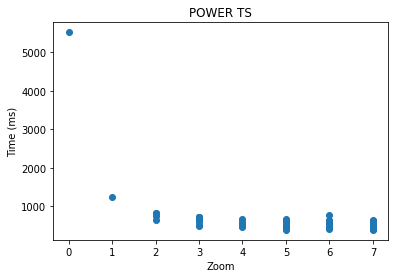

In [14]:
generate_zooms_plot(power_df, 'POWER TS')

# CMIP6 Historical Results (2° x 2.5°)

In [15]:
object_key = 'CMIP6_GISS-E2-1-G_historical_urls_stats.csv'
cmip6_df = pd.read_csv(s3_url(object_key))
cmip6_df.head()

,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,...,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%
0,GET,/tiles/0/0/0.png?reference=False&variable=tas&...,1,0,5972.127366,5972.127366,5972.127366,5972.127366,9409.0,0.015168,...,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000
1,GET,/tiles/1/1/0.png?reference=False&variable=tas&...,1,0,569.506351,569.506351,569.506351,569.506351,4193.0,0.015168,...,570,570,570,570,570,570,570,570,570,570
2,GET,/tiles/2/0/0.png?reference=False&variable=tas&...,1,0,530.119830,530.119830,530.119830,530.119830,1156.0,0.015168,...,530,530,530,530,530,530,530,530,530,530
3,GET,/tiles/2/2/0.png?reference=False&variable=tas&...,1,0,530.446978,530.446978,530.446978,530.446978,1229.0,0.015168,...,530,530,530,530,530,530,530,530,530,530
4,GET,/tiles/2/2/3.png?reference=False&variable=tas&...,1,0,643.725209,643.725209,643.725209,643.725209,1243.0,0.015168,...,640,640,640,640,640,640,640,640,640,640


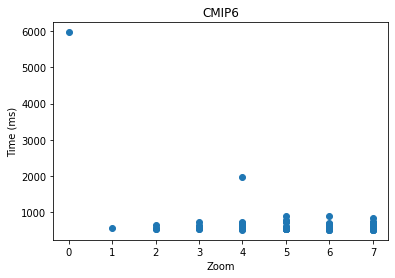

In [16]:
generate_zooms_plot(cmip6_df, 'CMIP6')

In [18]:
print(gpmimerg_df[-1:]['Median Response Time'])
print(goes_df[-1:]['Median Response Time'])
print(noaa_oisst_df[-1:]['Median Response Time'])
print(power_df[-1:]['Median Response Time'])
print(cmip6_df[-1:]['Median Response Time'])

98    310.0
Name: Median Response Time, dtype: float64
97    330.0
Name: Median Response Time, dtype: float64
96    470.0
Name: Median Response Time, dtype: float64
96    510.0
Name: Median Response Time, dtype: float64
99    580.0
Name: Median Response Time, dtype: float64
